# Data Analysis for Software Engineers

## Practical Assignment 4
## Getting Ready For Competition

<hr\>
**General Information**

**Due date:** 29 April 2018, 23:59 <br\>
**Competition deadline date:** 30 May 2018, 23:59 <br\>
**Competition link:** [here](https://www.kaggle.com/t/6d3fc375fd254010a1e781f91d6f6fc9)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import AdaBoostRegressor
import catboost as cb

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Load datasets

Load dataset. Get ready to find out that files are heavy..

You can find feature description on competition web-page

In [2]:
df_train = pd.read_csv('train_kaggle.csv.gz',
                       sep=';',
                       compression='gzip',
                       encoding='utf8',
                       usecols=['id', 'price', 'subcategory', 'description'])

In [3]:
df_test = pd.read_csv('test_kaggle.csv.gz',
                      sep=';',
                      compression='gzip',
                      encoding='utf8',
                      usecols=['id', 'subcategory', 'description'])

In [4]:
# df_train = df_train.get_chunk()
# df_test = df_test.get_chunk()

# Prepare dataset

## Target features transformation (1 point)

Look at target feature disctibution. 

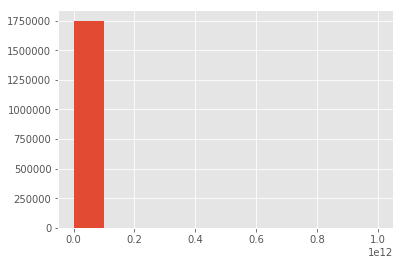

In [5]:
plt.hist(df_train['price']);

One might notive that it is heavy-tailed. Usually some transformation must be applied to provide better regression results.

Consider various transformations, like `np.log(x+1)`, `np.sqrt(x)` and etc.

Which of those provide better results? Make that transformation.

Dont forget to run inversed transformation during submission file preparation

In [6]:
df_train[df_train['price'] < 0] # Нашли какой-то wtf

,description,id,price,subcategory
1269516,Обратиться со всеми вопросами можно по телефон...,57bc738104559f4f50e9f3ac,-1,1005


In [7]:
df_train.iloc[1269516, 2] = 0

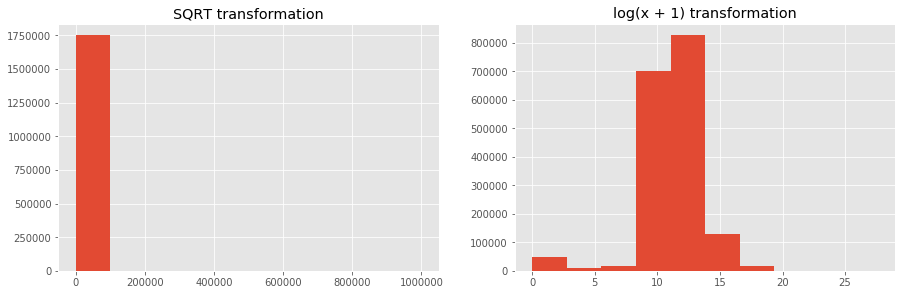

In [8]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.hist(np.sqrt(df_train['price']));
plt.title('SQRT transformation');
plt.subplot(222)
plt.hist(np.log(df_train['price'] + 1));
plt.title('log(x + 1) transformation');

Лучше результат показал log

In [9]:
df_train['price'] = np.log(df_train['price'] + 1)

## Raw Feature Preparation (1 point)

Our baseline model would consist of features `subcategory` and `description`.

First of all, we need go slighly polish them.

### Subcategory

Are there any difference between unique subcategory id in train and test? Show it.

In [10]:
len(df_train['subcategory'].unique())

250

In [11]:
len(df_test['subcategory'].unique())

248

Есть разница.

* Find out the union of subcategories from train and test. Assign it to some variable
* Initiallize `LabelEncoder`
* Fit `LabelEncoder` to it.
* Use `LabelEncoder` to map initial subcategories ids to number of 0 to C-1

In [12]:
all_subcategories = list(set(np.concatenate((df_train['subcategory'].unique(),
                                             df_test['subcategory'].unique()))))

In [13]:
len(all_subcategories)

251

In [14]:
le = LabelEncoder()

In [15]:
le.fit(all_subcategories)

LabelEncoder()

In [16]:
df_train['subcategory_new'] = le.transform(df_train['subcategory'])
df_test['subcategory_new'] = le.transform(df_test['subcategory'])

### Description

Description field is just a test. Sometimes it is missing (na). You should fill missing values with empty sting.

In [17]:
df_train['description'] = df_train['description'].fillna('')
df_test['description'] = df_test['description'].fillna('')

### Train and Test data

In [18]:
X = df_train.loc[:, ['subcategory_new', 'description']].values
y = df_train.loc[:, 'price'].values

X_test = df_test.loc[:, ['subcategory_new', 'description']].values
# y_test = df_test.loc[:, 'price'].values

# Base pipeline (1 point)

We are going to build a base pipeline, although one can find it not that simple

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col_idx):
        self.col_idx = col_idx
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[:, self.col_idx]

In [49]:
feature_preproc = FeatureUnion([
    ('cat_preproc', Pipeline(
        [
            ('select', ColumnSelector([0])),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ])),
    ('text_preproc', Pipeline(
        [
            ('select', ColumnSelector(1)),
            ('vect', TfidfVectorizer(min_df=20, max_df=0.9)),
        ]))
])

In [51]:
categorical_features_indices = np.where(df_train.dtypes != np.float)[0]

In [56]:
model = Pipeline([
    ('preproc', feature_preproc),
#     ('clf', SGDRegressor(random_state=123, max_iter=100))
#     ('clf', AdaBoostRegressor())
    ('clf', cb.CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE'))
])

Descripe what is going on in this pipeline.

To understand what `FeatureUnion` is look [here](http://michelleful.github.io/code-blog/2015/06/20/pipelines/)

In [57]:
def inverse_transformation(y):
    return np.power(2, y) - 1

## Training and Preparing submission

Train model and upload your submission

In [58]:
# %%time
model.fit(X, y)

CatboostError: Invalid data type=<class 'scipy.sparse.csr.csr_matrix'>: data must be list(), np.ndarray(), DataFrame(), Series() or filename str().

In [ ]:
y_hat = model.predict(X_test)
y_hat = inverse_transformation(y_hat)

In [ ]:
df_submission = pd.DataFrame(index=df_test.loc[:, 'id'], data=y_hat, columns=['price']).reset_index()

In [ ]:
df_submission.to_csv('my_base_submission.csv', sep=',', index=None)